In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pickle

from statsmodels.tsa.seasonal import seasonal_decompose

# Interactive widgets
import ipywidgets as widgets
from ipywidgets import interact, interact_manual

# Show all outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last_expr" # change to all, to show all

In [17]:
with open('tsprod.pickle', 'rb') as f:
    tsprod = pickle.load(f)
with open('tsfeed.pickle', 'rb') as f:
    tsfeed = pickle.load(f)
with open('tscrops.pickle', 'rb') as f:
    tscrops = pickle.load(f)

tsprod["Ethanol"]["DE"].head()

Tons      Value       Price
TIME_PERIOD                               
1988-01-01   2685.4  1442300.0  537.089447
1988-02-01   4195.2  2012402.0  479.691552
1988-03-01   4326.9  2296841.0  530.828307
1988-04-01   3629.1  1858971.0  512.240225
1988-05-01   5547.2  2682168.0  483.517450

In [18]:
for col in tsprod["LA"]["BE"].columns:
    print(col)
print(tsfeed.keys())

Tons
Value
Price
dict_keys(['Maize', 'Wheat', 'Beet'])


# Missing Data Imputation

Spain has missing data:
* 2 in Wheat
* 4 in Beet
* 65 in Maize (15%)

Upon inspection, Maize's missing data is concentrated in the months until 1993-06. This values were removed and the remaining values where interpoletd

France as 1 missing dat point in Maize

In [38]:
df = tsfeed['Beet']["ES"]
len(df)


425

In [19]:
df = tsfeed['Maize']["ES"]
print(len(df[df.index <= "1993-06"]))
df[df.index <= "1993-06"].isna().sum()

66


Tons     56
Value    56
Price    56
dtype: int64

Tons     0
Value    0
Price    0
dtype: int64


C:\Users\digval\AppData\Local\Temp\ipykernel_5336\976396607.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tsfeed['Maize']["ES"].Tons = tsfeed['Maize']["ES"].Tons.interpolate(option="linear")
C:\Users\digval\AppData\Local\Temp\ipykernel_5336\976396607.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tsfeed['Maize']["ES"].Value = tsfeed['Maize']["ES"].Value.interpolate(option="linear")
C:\Users\digval\AppData\Local\Temp\ipykernel_5336\976396607.py:16: SettingWithCopyWarning: 
A value is trying to b

<Axes: xlabel='TIME_PERIOD'>

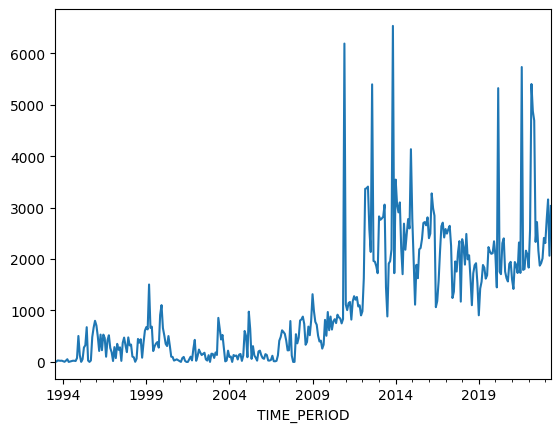

In [20]:
tsfeed['Wheat']["ES"].Tons = tsfeed['Wheat']["ES"].Tons.interpolate(option="linear")
tsfeed['Wheat']["ES"].Value = tsfeed['Wheat']["ES"].Value.interpolate(option="linear")
tsfeed['Wheat']["ES"].Price = tsfeed['Wheat']["ES"].Value / tsfeed['Wheat']["ES"].Tons

tsfeed['Beet']["ES"].Tons = tsfeed['Beet']["ES"].Tons.interpolate(option="linear")
tsfeed['Beet']["ES"].Value = tsfeed['Beet']["ES"].Value.interpolate(option="linear")
tsfeed['Beet']["ES"].Price = tsfeed['Beet']["ES"].Value / tsfeed['Wheat']["ES"].Tons

tsfeed['Maize']["FR"].Tons = tsfeed['Maize']["FR"].Tons.interpolate(option="linear")
tsfeed['Maize']["FR"].Value = tsfeed['Maize']["FR"].Value.interpolate(option="linear")
tsfeed['Maize']["FR"].Price = tsfeed['Maize']["FR"].Value / tsfeed['Wheat']["ES"].Tons

tsfeed['Maize']["ES"] = tsfeed['Maize']["ES"][tsfeed['Maize']["ES"].index > "1993-06"]
tsfeed['Maize']["ES"].Tons = tsfeed['Maize']["ES"].Tons.interpolate(option="linear")
tsfeed['Maize']["ES"].Value = tsfeed['Maize']["ES"].Value.interpolate(option="linear")
tsfeed['Maize']["ES"].Price = tsfeed['Maize']["ES"].Value / tsfeed['Wheat']["ES"].Tons

print(tsfeed['Maize']["ES"].isna().sum())
tsfeed['Maize']["ES"].Tons.plot()

In [21]:
tsfinal = {}
tsfinal["prod"] = tsprod
tsfinal["feed"] = tsfeed
tsfinal["crops"] = tscrops
with open(f'tsfinal.pickle', 'wb') as f:
    pickle.dump(tsfinal, f)

In [22]:
with open('tsfinal.pickle', 'rb') as f:
    ts = pickle.load(f)
ts["feed"]["Beet"]["FR"].head()

Tons     Value       Price
TIME_PERIOD                              
1988-01-01   3419.2  398339.0  116.500643
1988-02-01    870.5   95431.0  109.627800
1988-03-01    891.3  114688.0  128.674969
1988-04-01    269.6   39595.0  146.865727
1988-05-01     44.7    3834.0   85.771812

# Exploratory Data Analyisis

## Seasonal Decomposition

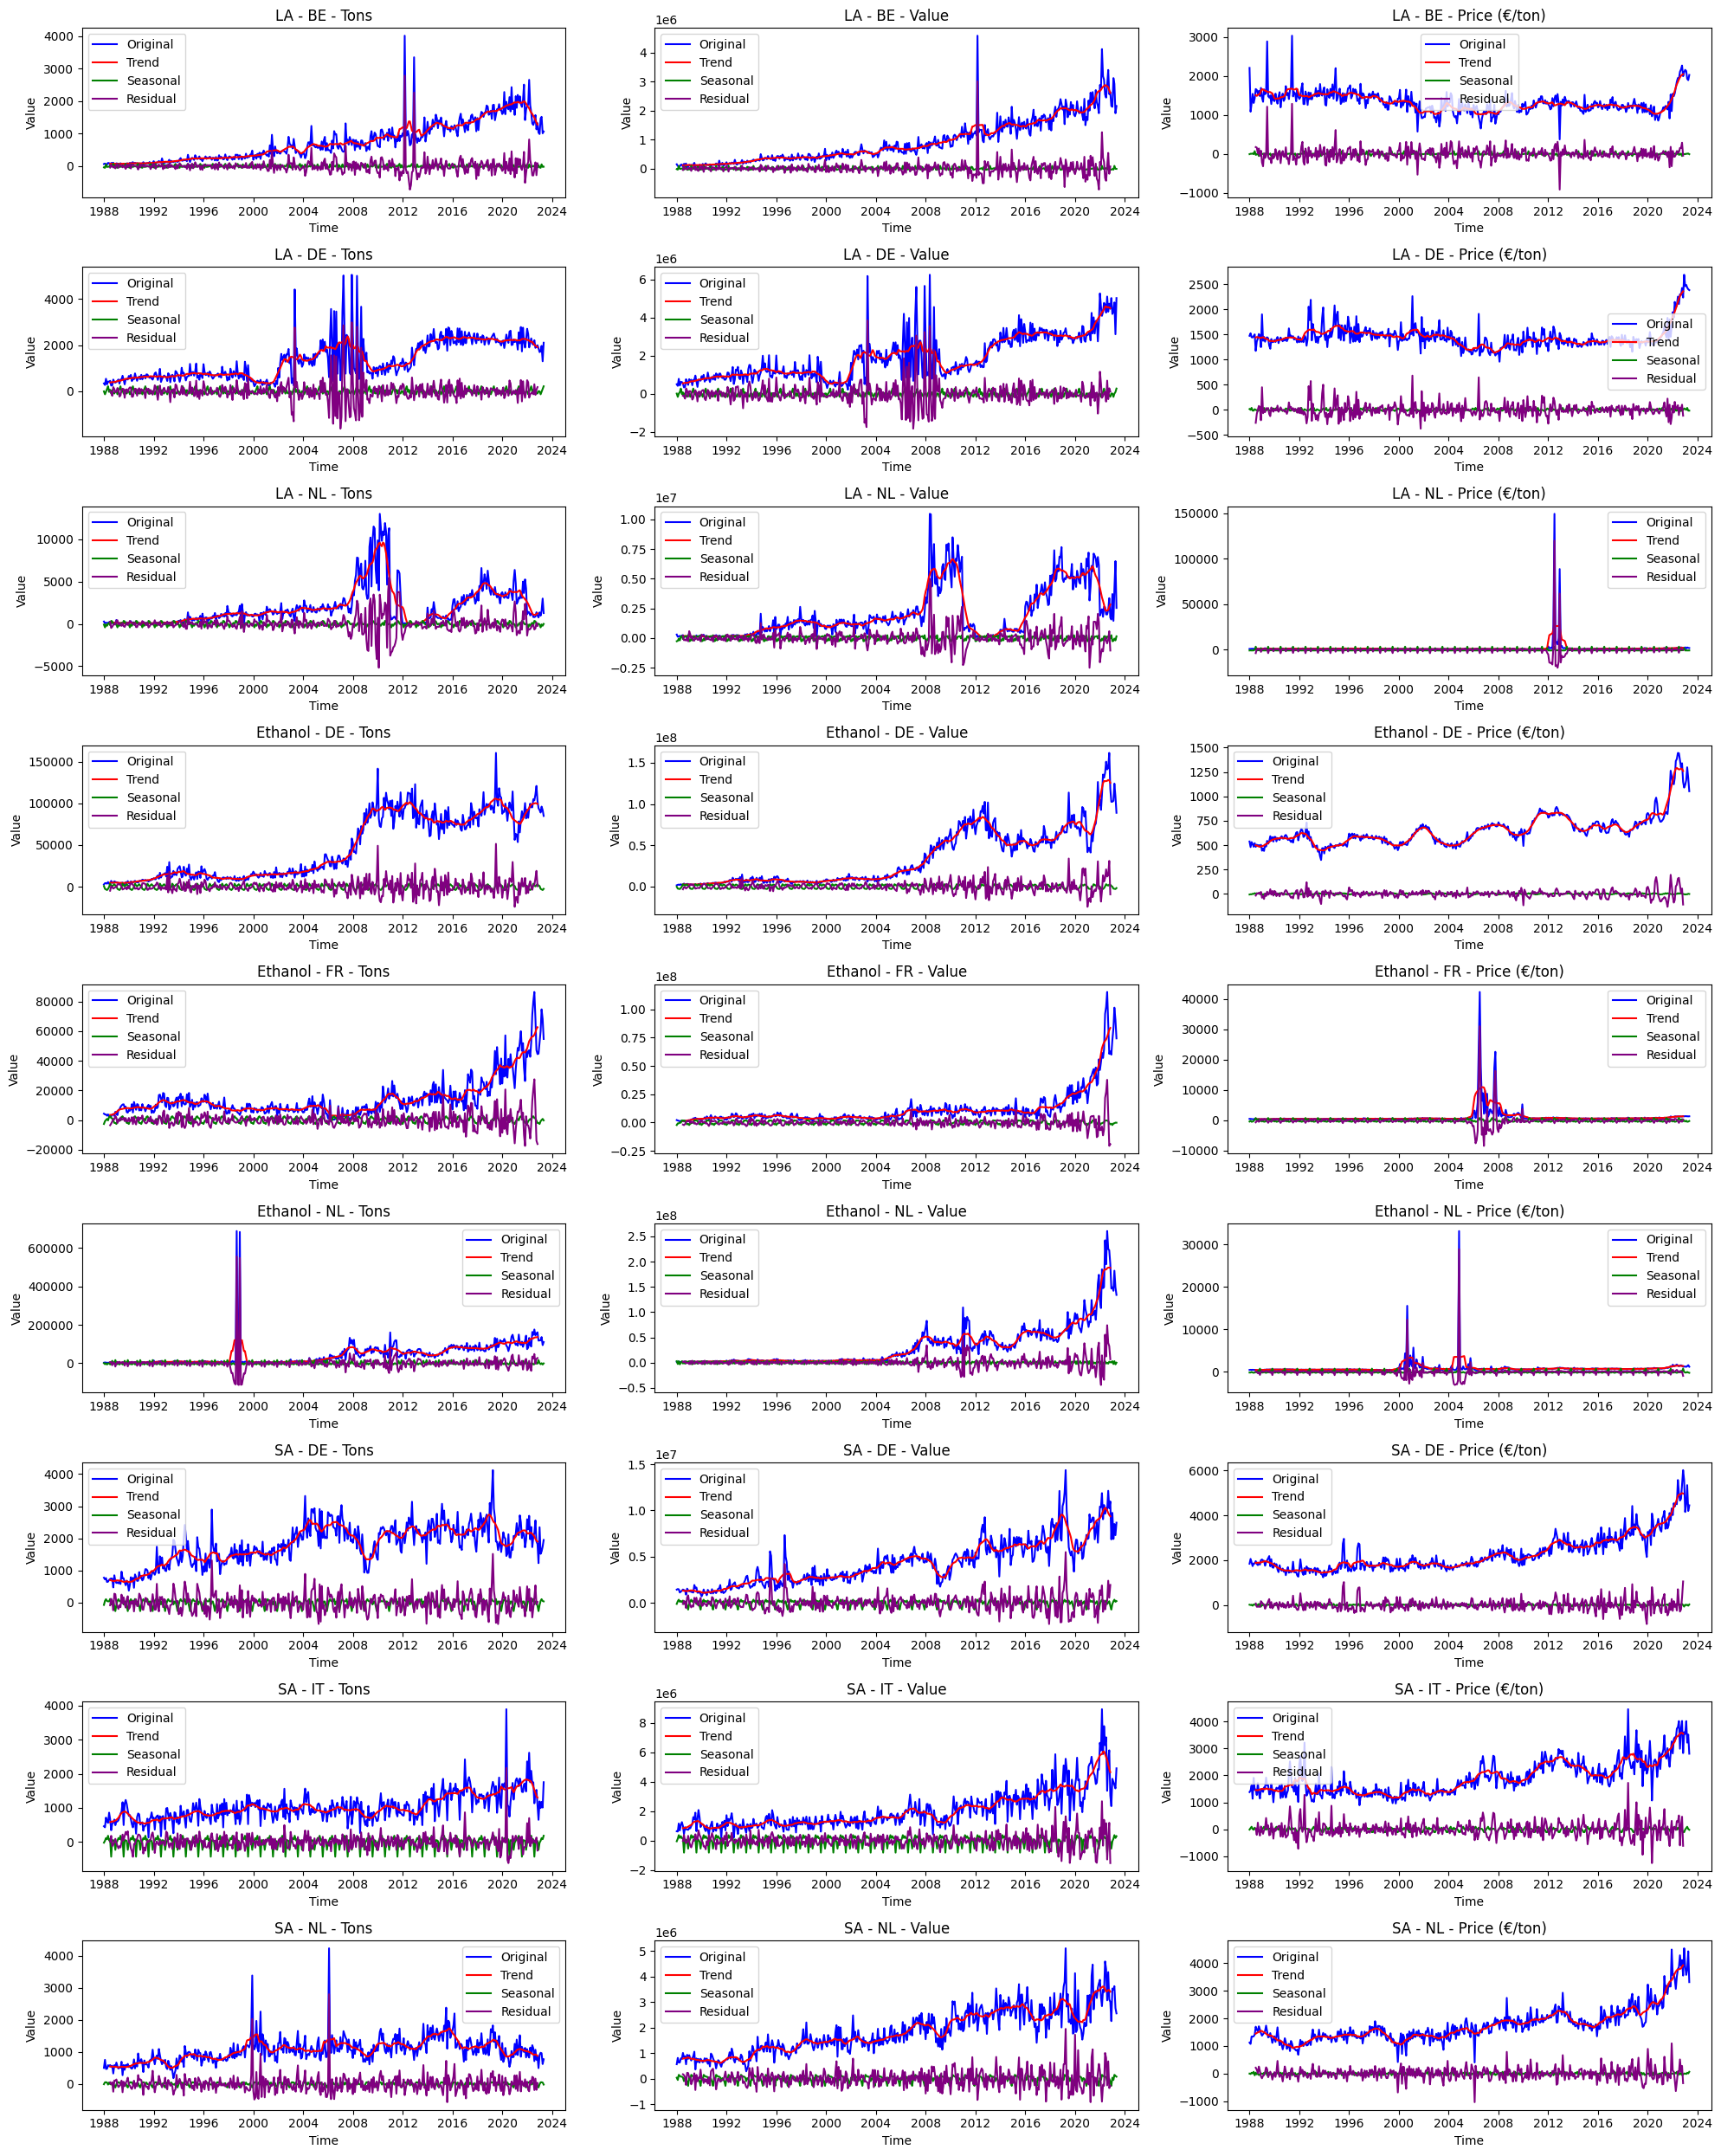

In [23]:
# Set up subplot layout
num_rows = 9
num_cols = 3
fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 25))
plt.subplots_adjust(wspace=0.4, hspace=0.4)

# Iterate through time series and plot seasonal decomposition
i = 0
for p in tsprod.keys():
    for geo in tsprod[p].keys():
        for field in tsprod[p][geo].columns:
            row = i // num_cols
            col = i % num_cols
            ax = axes[row, col]
            ts = tsprod[p][geo][field]
            # Perform seasonal decomposition
            result = seasonal_decompose(ts, model='additive')

            # Plot decomposition components
            ax.plot(ts, label='Original', color='blue')
            ax.plot(result.trend, label='Trend', color='red')
            ax.plot(result.seasonal, label='Seasonal', color='green')
            ax.plot(result.resid, label='Residual', color='purple')

            field = "Price (€/ton)" if field == "Price" else field
            ax.set_title(f'{p} - {geo} - {field}')
            ax.set_xlabel('Time')
            ax.set_ylabel('Value')
            ax.legend()
            i += 1

# Display the plot
plt.tight_layout()
plt.show()

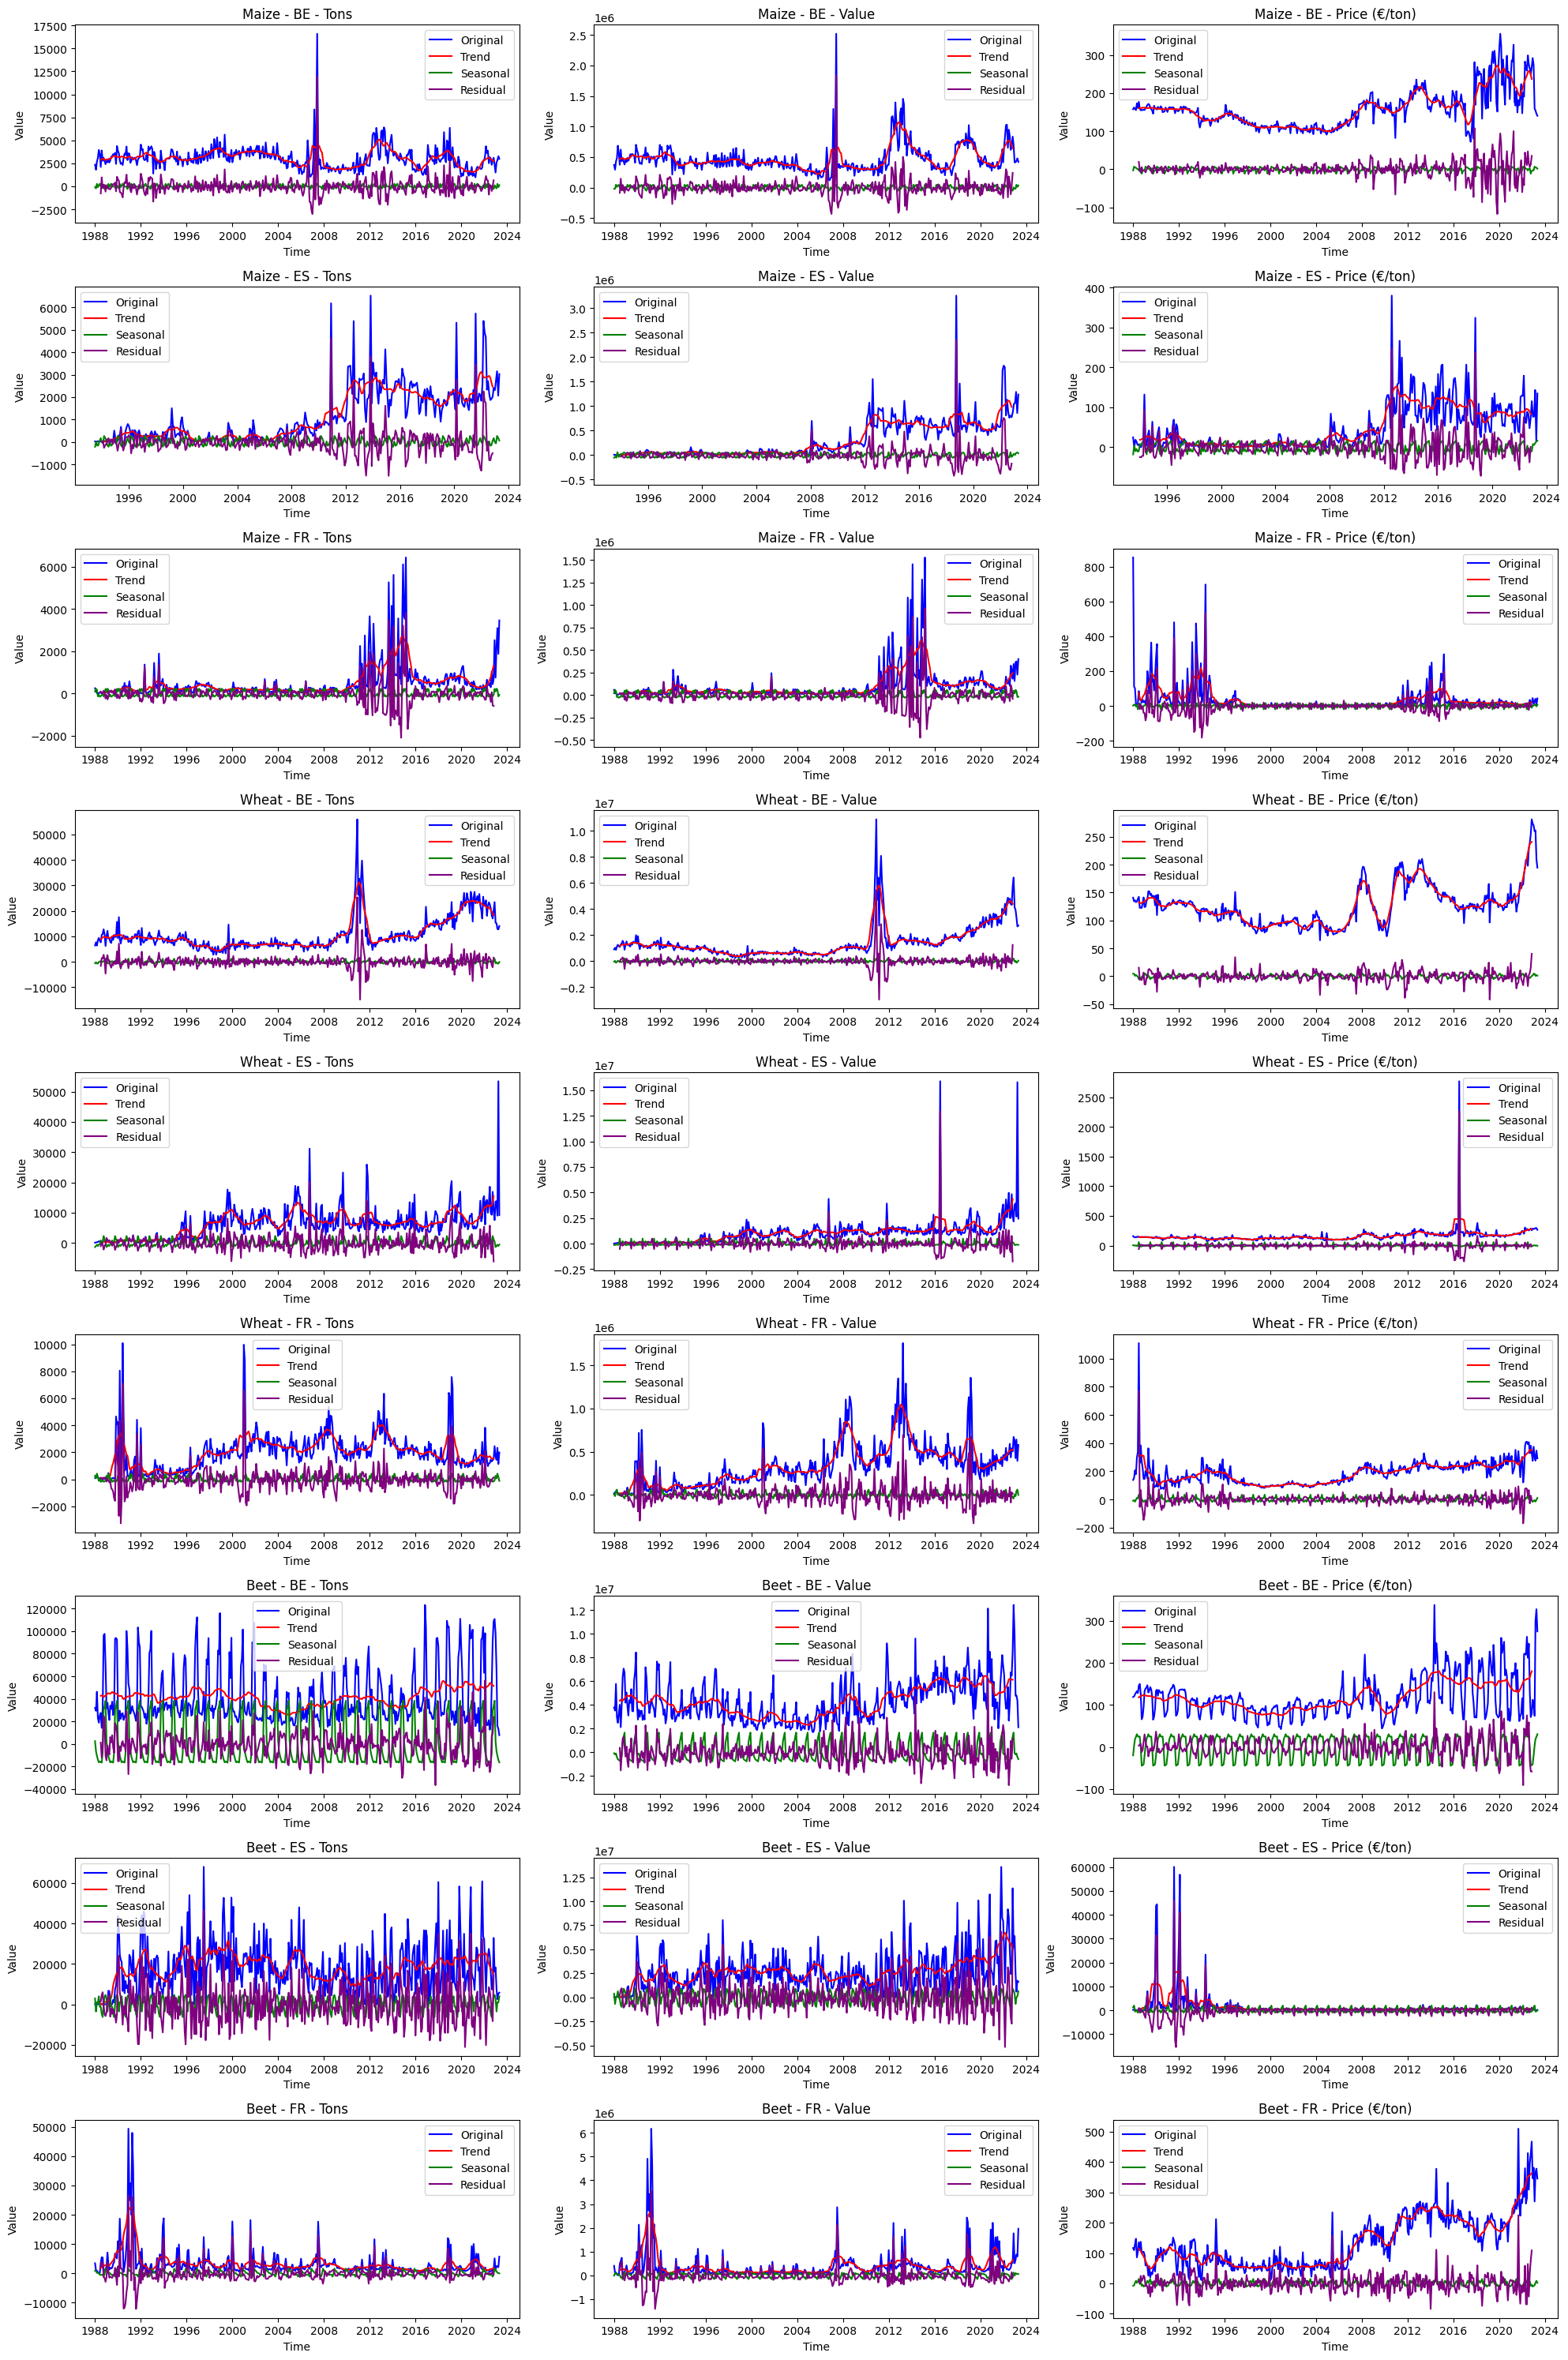

In [24]:
# Set up subplot layout
num_rows = 9
num_cols = 3
fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 30))
plt.subplots_adjust(wspace=0.4, hspace=0.4)

# Iterate through time series and plot seasonal decomposition
i = 0
for p in tsfeed.keys():
    for geo in tsfeed[p].keys():
        for field in tsfeed[p][geo].columns:
            row = i // num_cols
            col = i % num_cols
            ax = axes[row, col]
            ts = tsfeed[p][geo][field]

            # Perform seasonal decomposition
            result = seasonal_decompose(ts, model='additive')

            # Plot decomposition components
            ax.plot(ts.dropna(), label='Original', color='blue')
            ax.plot(result.trend, label='Trend', color='red')
            ax.plot(result.seasonal, label='Seasonal', color='green')
            ax.plot(result.resid, label='Residual', color='purple')

            field = "Price (€/ton)" if field == "Price" else field
            ax.set_title(f'{p} - {geo} - {field}')
            ax.set_xlabel('Time')
            ax.set_ylabel('Value')
            ax.legend()
            i += 1

# Display the plot
plt.tight_layout()
plt.show()

In [8]:
tscrops['Beet']['ES'].head()

Mtons_Waste
TIME_PERIOD             
2000           35.207868
2001           29.992644
2002           36.396012
2003           28.261044
2004           31.856556

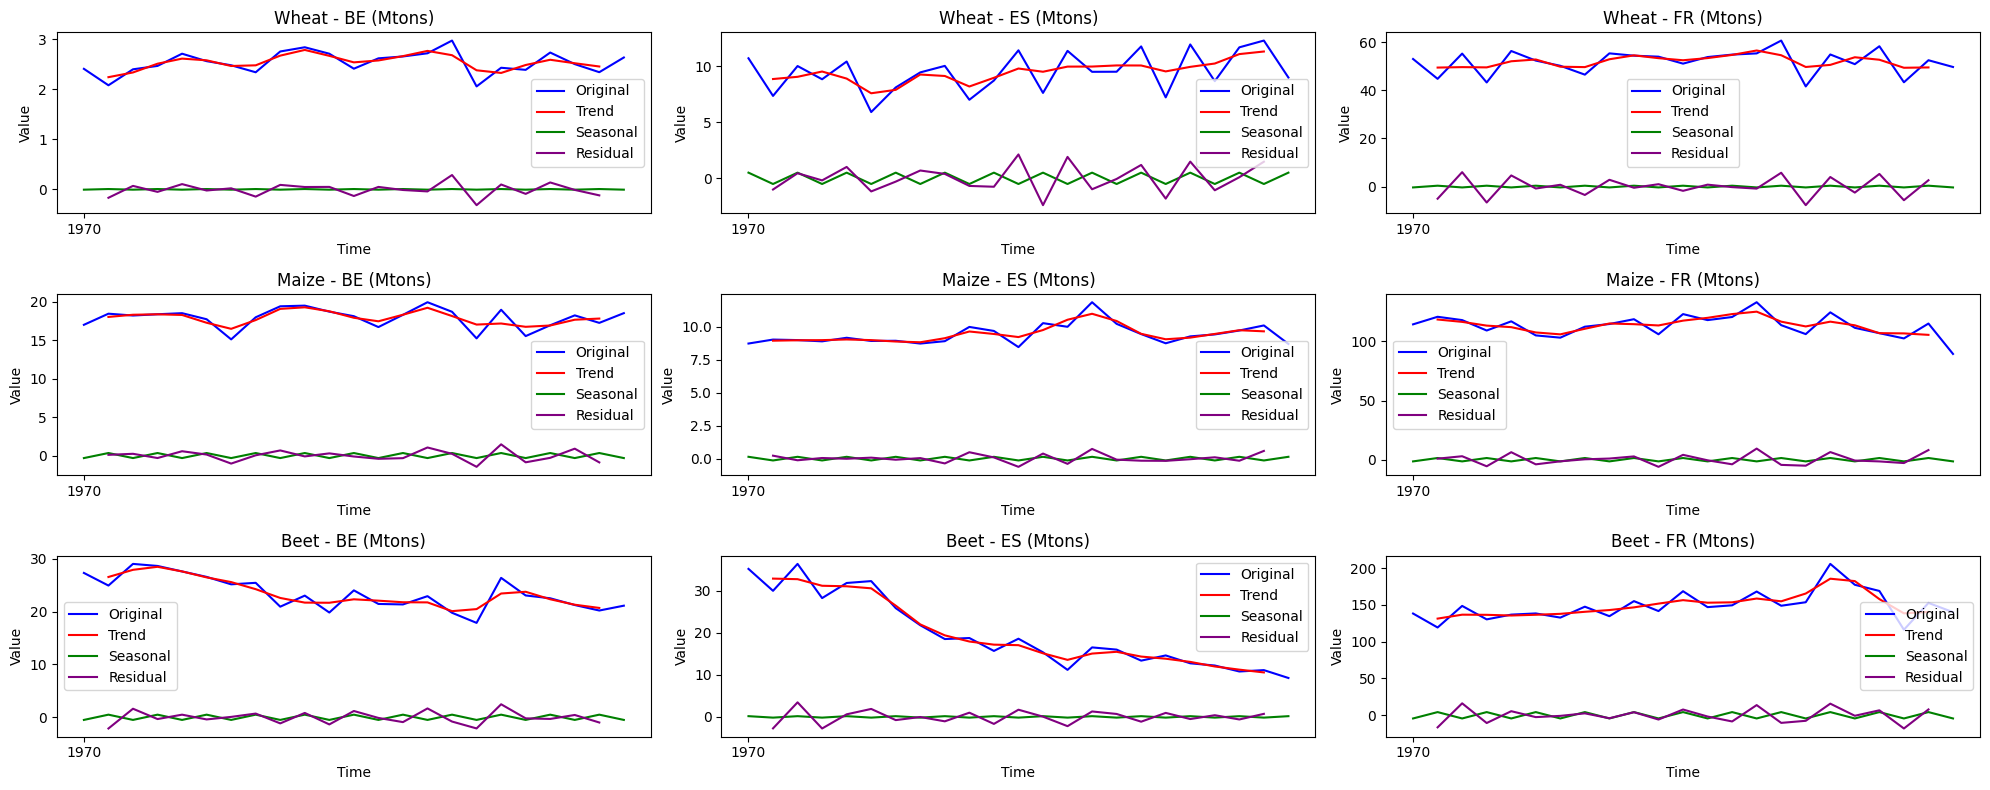

In [12]:
# Set up subplot layout
num_rows = 3
num_cols = 3
fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 8))
plt.subplots_adjust(wspace=0.4, hspace=0.4)

# Iterate through time series and plot seasonal decomposition
i = 0
for p in tscrops.keys():
    for geo in tscrops[p].keys():
            row = i // num_cols
            col = i % num_cols
            ax = axes[row, col]
            tscrops[p][geo].index = pd.to_datetime(tscrops[p][geo].index)
            ts = tscrops[p][geo].Mtons_Waste
            # Perform seasonal decomposition
            result = seasonal_decompose(ts, model='additive', period= 2)

            # Plot decomposition components
            ax.plot(ts.dropna(), label='Original', color='blue')
            ax.plot(result.trend, label='Trend', color='red')
            ax.plot(result.seasonal, label='Seasonal', color='green')
            ax.plot(result.resid, label='Residual', color='purple')

            ax.set_title(f'{p} - {geo} (Mtons)')
            ax.set_xlabel('Time')
            ax.set_ylabel('Value')
            ax.legend()
            i += 1

# Display the plot
plt.tight_layout()
plt.show()

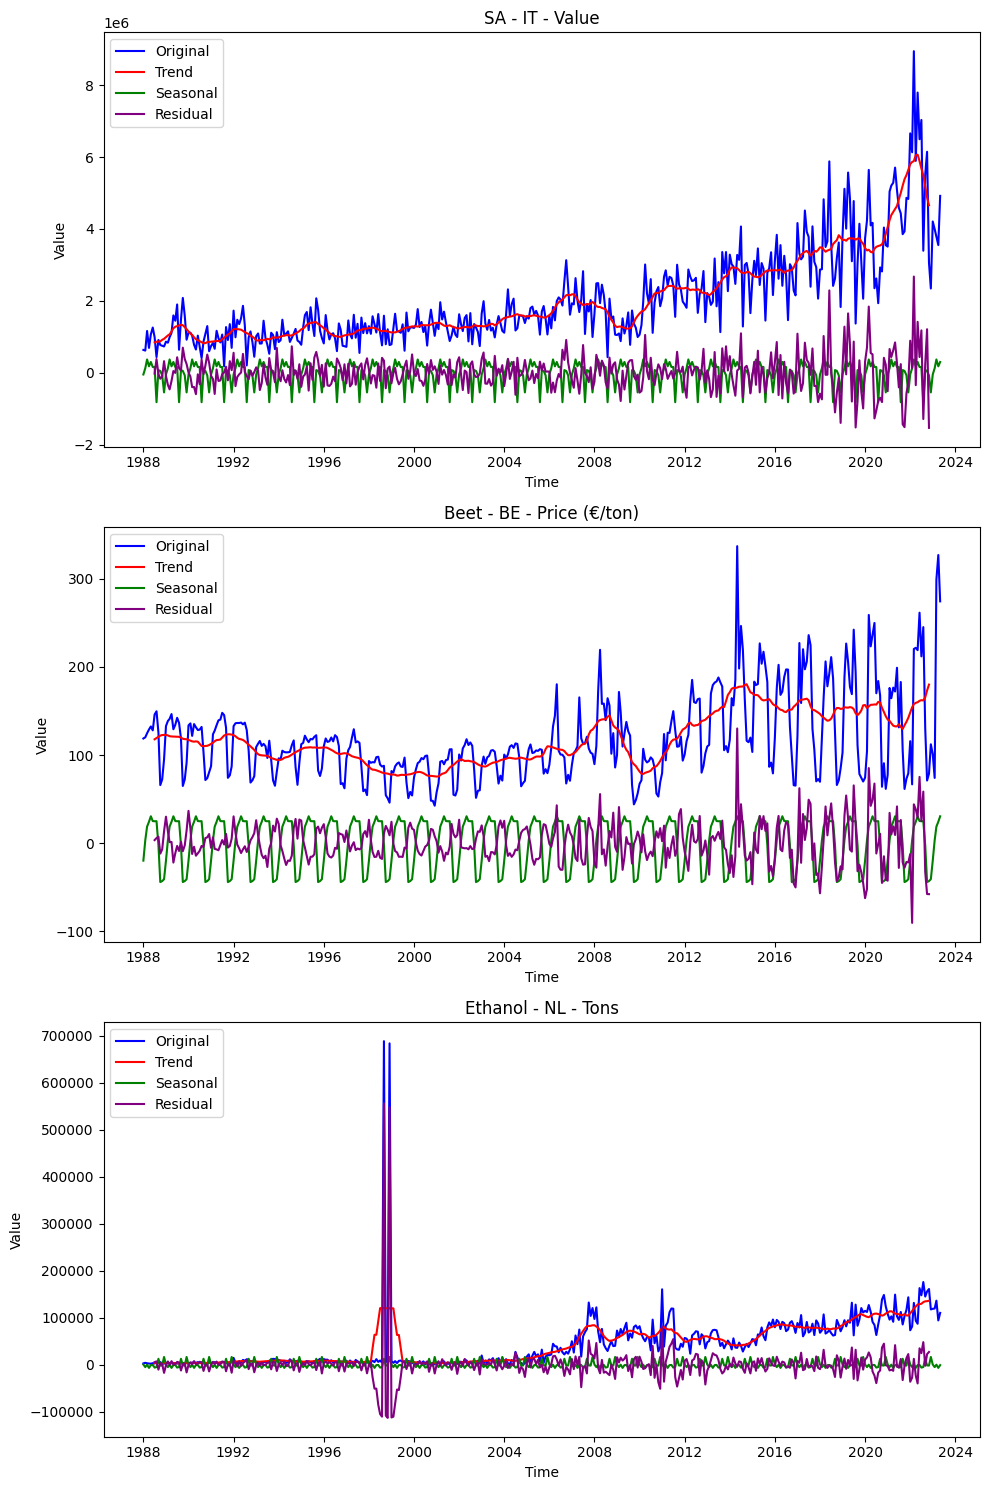

In [37]:
num_rows = 3
num_cols = 1
fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 15))
plt.subplots_adjust(wspace=0.4, hspace=0.4)

ds=[
    ["SA", "IT", "Value"],
    ["Beet", "BE", "Price"],
    ["Ethanol", "NL", "Tons"]
]

# Iterate through time series and plot seasonal decomposition
i = 0
for df in ds:

    p = df[0]
    geo = df[1]
    field = df[2]
    row = 1
    col = i 
    ax = axes[col]
    try:
        ts = tsprod[p][geo][field]
    except:
        ts = tsfeed[p][geo][field]
    # Perform seasonal decomposition
    result = seasonal_decompose(ts, model='additive')

    # Plot decomposition components
    ax.plot(ts, label='Original', color='blue')
    ax.plot(result.trend, label='Trend', color='red')
    ax.plot(result.seasonal, label='Seasonal', color='green')
    ax.plot(result.resid, label='Residual', color='purple')

    field = "Price (€/ton)" if field == "Price" else field
    ax.set_title(f'{p} - {geo} - {field}')
    ax.set_xlabel('Time')
    ax.set_ylabel('Value')
    ax.legend()
    i += 1
    ax.legend( loc='upper left')

# Display the plot
plt.tight_layout()
plt.show()

In [28]:
axes

array([<Axes: >, <Axes: >, <Axes: >], dtype=object)